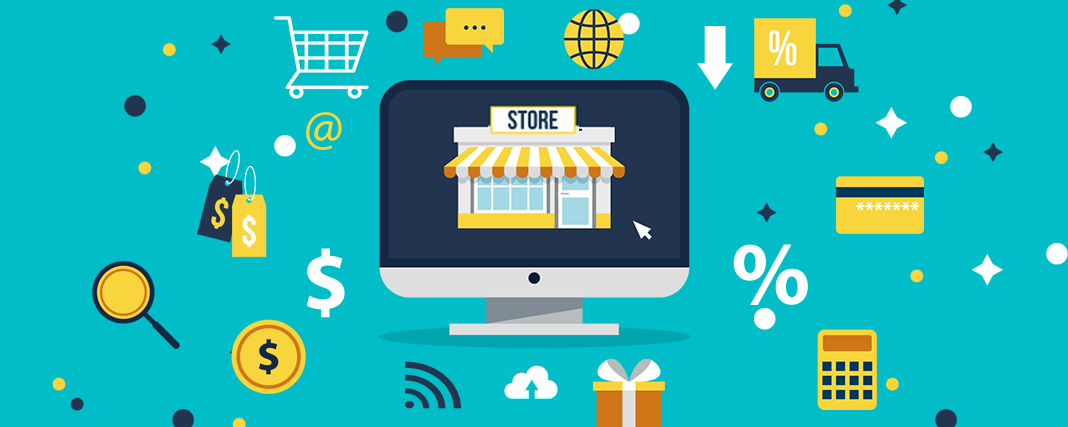

** <h2> E-commerce customer's data exploration and segmentation </h2> **

The DataFrame contains the information about customer's purchases across United Kingdom.
There are nearly about 4000 customers and their purchases during the period of one year (**from 2010-12-01 to 2011-12-09**). 

The analysis will be divided into several parts:
1. Data Importing and Data Cleaning.
2. Cohort Analysis of customers based on Time Cohorts.
3. Recency, Frequency and Monetary Value Analysis (RFM).
4. Customer Segmentation using K-Means Algorithm. 
5. Conclusion.


Today Customer and Cohort Analysis is the must have knowledge for any data-scientist or data-analyst. Cohort analysis is one of the most effective way to gather information about customer's behaviour. Before dive in I want to clarify some points of the analysis. Further you will not find any super complex concepts of machine learnign models or neural networks. The main goal of this notebook is simply try to show you how to build a full pipeline to analyze customer's behaviour on the basis of E-commerce data. And maybe some part of this notebook will clarify your mind on some simple points of the customer analysis.

So, terminology:
* **Cohort** - group of people (users, individuals and etc.) who have a common characteristic(-s) during a period of time.
* **Cohort Analysis** - a subset of behavioral analytics that researches groups of people who have taken a common action during a selected period of time
* **Retention** - the continued possesion, use, or control something
* **Churn** - the user (customer) who has stopped using the service

Furthermore, outside from this notebook you can face with such types of cohorts as:
* Time Cohorts (So called Retention)
* Behavior Cohorts (RFM, LFL and other variations of analysis)
* Size Cohorts (Clustering, Behavior Patterns Segmentation and etc.)


So from this point I will stop. Let's go dive dipper into analytics.


In [ ]:
import pandas as pd                 # data manipulation
import numpy as np                  # linear algebra
import matplotlib.pyplot as plt     # basic plotting 
import seaborn as sns               # plotting libriary
import datetime as dt                  # basic date and time types                    
import warnings    
import math
import time
import re
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
plt.style.use(style = 'tableau-colorblind10')
plt.rcParams['figure.figsize'] = (15, 10)
os.getcwd()
os.listdir(os.getcwd())

<h3> **Part 1. Data Importing And Data Cleaning** </h3>

The E-Commerce DataFrame contains the following columns:
* **InvoiceNo** - datatype string
* **Stock Code** - datatype string
* **Description** - datatype string
* **Quantity** - datatype integer
* **InvoiceDate** - datatype datetime
* **UnitPrice** - datatype float
* **CustomerID** - datatype string
* **Country** - datatype string

In [ ]:
file_path = '/kaggle/input/ecommerce-data/data.csv'

dtypes = {'InvoiceNo' : str, 'StockCode' : str, 'Description' : str, 'Quantity' : int,
          'UnitPrice' : float, 'CustomerID' : str, 'Country' : str}

In [ ]:
online = pd.read_csv(file_path, encoding = 'latin1', dtype = dtypes)
online.head()

In [ ]:
online.info()

Let's check if we have a missing values in the DataFrame. 
If so I think I will delete it because I will not build a complex machine learning model and the 
data quantity in such case does not matter.

In [ ]:
online[online.Description.isna()]

So the columns Description and CustomerID have missing values. 
Delete them.

In [ ]:
online.dropna(inplace = True)
online.info()

In [ ]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [ ]:
online.dtypes

In [ ]:
online.head()

In [ ]:
# Check the date variations in the DataFrame
print("Min Date: {} \t Max Date: {}".format(online['InvoiceDate'].min(), online['InvoiceDate'].max()))

In [ ]:
# Check how many customers the DataFrame have and how many purchases they made
len(online['CustomerID'].value_counts())
# So there are 4372 unique customers that have made the purchases during the period of 1 year.

In [ ]:
# Check quantity of positions 
print("The number of sell positions are {}.\n".format(len(online['Description'].value_counts())))

# So cutomers spread over 3896 position. I am interested what product have the most popularity.
print("The most popular merchandise in the E-commerce shop: \n\n{}.".format(online['Description'].value_counts()[:10]))

I found one interesting thing in the dataFrame. The **Quantity** column has a negative value in it. But logically it should not, because the customer can not buy a negative amount of merchant. It is impossible. But maybe it is a way that store register such sales as installment plan. But maybe I am wrong.

Also the **UnitPrice** column have zero price rows. It means that we sell for free. But it is also impossible. Seems like there are a mistake in data or something is wrong.

So I will find such rows and just delete them in order to fully clean the dataFrame.

In [ ]:
online.describe()

In [ ]:
online = online[online['Quantity'] > 0]
online = online[online['UnitPrice'] > 0.05]
online.describe()

So it seems that the dataFrame is cleaned. Data Types are correct and logically spreaded. So let's dive in into the second part of the Analysis - Cohort Analysis of customers based on the Time Cohorts.

Before it lets select only United Kingdom customers in order to avoid Time Zone Collapsing and other inappropriate data problems. The list of countries can be found below.

In [ ]:
online['Country'].value_counts()

In [ ]:
online = online[online['Country'] == 'United Kingdom']

In [ ]:
online.head()

<h3> **Part 2. Cohort Analysis of customers based on Time Cohorts. ** </h3>


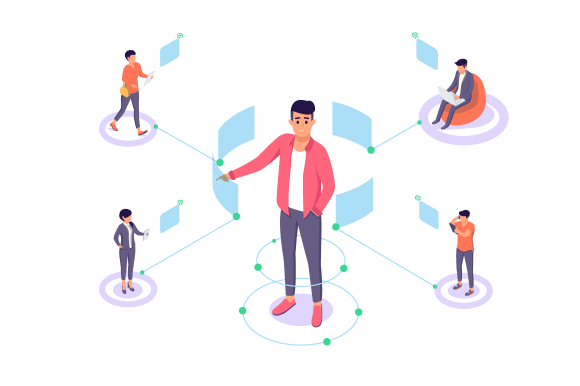

Defining a cohort is the first step to cohort analysis. Let's try to create daily (or maybe other time types cohorts) cohorts based on the day each customer has made their first transaction (received an InvoiceNo due to the InvoiceDate).

To do this I will create a function that accepts a datetime datatype (object) and returns such values as year, month and day from specified column.

In [ ]:
online.head()

In [ ]:
# Define a function that will parse the dates from datetime object
def extract_days(x):
    """
    The function extract_dates receives a datetype object from a specified column and return
    splitted values into year, month and day.
    
    Usage:
    extract_dates(df['datetime object column'])
    or
    df['datetime_object_column'].apply(extract_dates)
    
    Returns:
    Series object:
    2020-02-01
    2020-02-02
    ..........
    2020-02-29
    
    Exceptions:
    This function is applied by the .apply() method if dataframe datetime column is passed.
    """
    return dt.datetime(x.year, x.month, x.day)

In [ ]:
# Create InvoiceDay column that contains invoice dates issue by applying extract_dates function
online['InvoiceDay'] = online['InvoiceDate'].apply(extract_days)

# Groupby InvoiceDay column
grouping = online.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min')

# View the top 5 rows
print(online.head())

In [ ]:
# Let do the another column that contains month cohort and invoice month for cohorts
# I will not describe what the function does as you can read similar to this above
def extract_month_int(x):
    return dt.datetime(x.year, x.month, 1)

# Create a column InvoiceMonth
online['InvoiceMonth'] = online['InvoiceDate'].apply(extract_month_int)

# Group
grouping = online.groupby('CustomerID')['InvoiceMonth']

# Assign new column
online['CohortMonth'] = grouping.transform('min')

# Show several rows of transformed data
online.head()

In [ ]:
def extract_dates_int(df, column):
    """
    The function extract_dates_int help to divide datetime column into several columns based
    on splitting date into year, month and day.
    
    Usage:
    extract_dates_int(dataFrame, dataFrame['DateTime_Column'])
    
    Returns:
    tuple object that contains unique years, months and days.
    
    ((416792    2011
      482904    2011)
      ..............
      482904    11
      263743     7
      ..............
      482904    11
      263743     7
    
    Type:
    function
    
    """
    # extract years from datetime column
    year = df[column].dt.year
    
    # extract months from datetime column
    month = df[column].dt.month
    
    # extract days from datetime column
    day = df[column].dt.day
    
    return year, month, day

So the next step in order to build an appropriate cohorts is to calculate time offsets for each customer transaction. It will allow us to report the metrics for each cohort in an appropriate way. To create time offsets I will create the function that splits the dates into year, month, day columns. It will help to easily do calculations based on time dates.

In [ ]:
# Get the integers for date parts from 'InvoiceDay' column and 'CohortDay' column

# InvoiceDay column manipulation
invoice_year, invoice_month, _ = extract_dates_int(online, 'InvoiceMonth')

# CohortDay column manipulation
cohort_year, cohort_month, _ = extract_dates_int(online, 'CohortMonth')

So from this point it is available to calculate an appropriate time offsets in days (or other time periods). We have six different data sets with year, month and day values for such columns as InvoiceDay and CohortDay:
* invoice_year
* invoice_month
* invoice_day
* cohort_year
* cohort_month
* cohort_day

So lets try to calculate the difference between the Invoice and Cohort dates in years, month and days separately and then calculate the total days difference between this two. And this will be days offsets which will be used in the customer cohort building.

In [ ]:
# calculation of the difference in years
years_difference = invoice_year - cohort_year

# calculation of the difference in months
months_difference = invoice_month - cohort_month

In [ ]:
# Extract the difference in days from all the previous extracted values above and create 
# new column called CohortIndex

# ~365 days in one year, ~30 days in one month and plus 1 day to differ from zero value
online['CohortIndex'] = years_difference * 12 + months_difference + 1
online.head()

So the next step is creation of the retention table and research the retention table from customers data. Customer retention is very powerful metric to understand how many of all the customers are still 'alive' (or active). Before that Retention shows us a percentage of active customers out of total customers.

In [ ]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per CustomerID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Creating cohort pivot table 
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID')

# Review the results
cohort_counts

In [ ]:
# Select the first column and store value in cohort_sizes
cohort_sizes = cohort_counts.iloc[:, 0]

# Calculate Retention table by dividing the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis = 0)

# Review the retention table
retention.round(3) * 100

Another useful metric for behavioural analytics and customer analytics is to calculate tha average quantity of products that customers buy in the E-Commerce store and visualise it in similar cohort table like above for the retention analytics.

In [ ]:
grouping_avg_quantity = online.groupby(['CohortMonth', 'CohortIndex'])

# Extract Quantity column from grouping and calculate its mean value
cohort_data_avg_quantity = grouping_avg_quantity['Quantity'].mean().reset_index()

# average quantity table similar to retention but showing the change in quantity of products purchased
average_quantity = cohort_data_avg_quantity.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'Quantity')
average_quantity.round(1).fillna('')

So we are in the final of Part 2. The last action to build a complex cohort and retention analysis is to visualise results that we have calculated above. The best choice to show the obtained results is to draw a heatmap that will show us a retention graph of customer data (cohorts and retention). So lets do it!

In [ ]:
# Build a figure
plt.figure(figsize = (10, 8))
plt.title('Retentoin rate for customers')

# Initialize a heatmap grapgh 
sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.01, vmax = 0.5, cmap = 'BuGn')

# show the retention graph
plt.show()

In [ ]:
# Build a figure
plt.figure(figsize = (10, 8))
plt.title('average_quantity for customers')

# Initialize a heatmap grapgh 
sns.heatmap(data = average_quantity, annot = True, vmin = 0.01, vmax = 0.5, cmap = 'BuGn')

# show the retention graph
plt.show()

So that's it to Part 2. Now you can create a retention cohorts. 

<h3> **Part 3. Recency, Frequency and Monetary Value Analysis (RFM).** </h3>

**RFM Segmentation** is another type of customer segmentation based on three factors:

* Recency (R) - measures how recent was each customer's last purchase
* Frequency (F) - measures how many purchases customer has done in the last N periods 
* Monetary Value (M) - measures how much has customer spent in the last N periods

As soon as values are calculated the next step is grouping them into categories (or some sort of it) such as high, medium and low. The RFM values can be grouped in such ways as:

* Percentiles (I will implement this method)
* Pareto law (split metrics on high and low values)
* Custom (based on specific domain knowledge which you can use further)

In [ ]:
# Creating TotalSum Column in order to define a total amount spent by customers during the period
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
online.head()

The dataFrame starting with only latest 12 month of data. Create a hypothetical snapshot_day data as we are doing analysis recently.

In [ ]:
print('Min_date {} \nMax_date {}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

In [ ]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days = 1)

In [ ]:
# Calculate Recency, Frequency and Monetary Values for each customer in the dataFrame
rfm_data = online.groupby(['CustomerID']).agg({
                                                'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
                                                'InvoiceNo' : 'count',
                                                'TotalSum' : 'sum'
                                                })

# Rename the created data columns in order to interpritate the obtained results
rfm_data.rename(columns = {
                            'InvoiceDate' : 'Recency',
                            'InvoiceNo' : 'Frequency',
                            'TotalSum' : 'MonetaryValue'
                            }, inplace = True)

# Check the obtained results
rfm_data.head()

Now let's create three separate groups based on Recency, Frequency and Monetary Value of customers.

In [ ]:
# Labels for Recency, Frequenct and Monetary values metrics
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# Recency metric quartiles
r_quartiles = pd.qcut(rfm_data['Recency'], 4, labels = r_labels)
rfm_data = rfm_data.assign(R = r_quartiles.values)

# Frequency metric quartiles
f_quartiles = pd.qcut(rfm_data['Frequency'], 4, labels = r_labels)
rfm_data = rfm_data.assign(F = f_quartiles.values)

# Monetary Value metric quartiles
m_quartiles = pd.qcut(rfm_data['MonetaryValue'], 4, labels = m_labels)
rfm_data = rfm_data.assign(M = m_quartiles.values)

In [ ]:
rfm_data.head()

Now it is high time to build so called RFM Segment and RFM Score. RFM score is a simply sum of the Recency, Frequency and Monetary Values and this sum is a result of integer values like 10, 9, 8 and etc. This score will indicate the value of RFM score that will allow us to make decisions on a business product or on our customers. This is very important metric due to future decision-making process concerning the users or customers. 

In [ ]:
# Define function concat_rfm that will concatenate integer to string value
def concat_rfm(x):
    """
    Function which return a concatenated string from integer values.
    """
    return str(x['R']) + str(x['F']) + str(x['M'])

# Calculate the RFM segment 
rfm_data['RFM_Segment'] = rfm_data.apply(concat_rfm, axis = 1)

# Calculate the RFM score which is the sum of RFM values
rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis = 1)

In [ ]:
rfm_data.head()

In [ ]:
# Explore the RFM score in the rfm_data
rfm_data.RFM_Score.value_counts().sort_index()

In [ ]:
# Explore the RFM segment in the rfm_data
rfm_data.RFM_Segment.value_counts().sort_values(ascending = False)[:10]

The next step is optional. If you will present the obtained result to your boss you will need to interpret the results into humanlike language. Because not all people understand the language of math on which speaks a lot of poeple in our industry (Data Science).

So the better way to interpret the obtained results is to assign a humanlike value to each of the RFM segment based on the RFM score. What I mean here? For example the RFM Score which is greater than 10 will be called Top,
the RFM Score between 6 and 10 will be called Middle and the final RFM Score lower than 6 will be called Low. So let's do it.

In [ ]:
# Function that assigns a humanlike label to each of the RFM segment based on the RFM scores
def auto_rfm_level(df):
    """
    Function that auto assigns humanlike segment to each RFM Segments.
    """
    if df['RFM_Score'] >= 8:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Middle'
    else:
        return 'Low'



# In order to save the RFM labels create a new column where to store it
rfm_data['RFM_Level'] = rfm_data.apply(auto_rfm_level, axis = 1)

# Explore the obtained results
rfm_data.head()

In [ ]:
# Explore the obtained RFM levels
print("Absolute values \n{} \n\nRelative values \n{}".format(rfm_data.RFM_Level.value_counts(),rfm_data.RFM_Level.value_counts(normalize = True)))

In [ ]:
# Let's dig deeper into the RFM Score
rfm_data.groupby('RFM_Score').agg({
                                    'Recency' : 'mean',
                                    'Frequency' : 'mean',
                                    'MonetaryValue' : ['mean', 'count']
}).round(1)

In [ ]:
# Let's dig deeper into the RFM Score
rfm_data.groupby('RFM_Level').agg({
                                    'Recency' : 'mean',
                                    'Frequency' : 'mean',
                                    'MonetaryValue' : ['mean', 'count']
}).round(1)

That's it we have created useful RFM (behavioural segmentation) based on user's data (customer's data). The interpritation is simple the lower Recency the better and the higher Frequency and Monetary Value the better. Finally we divided our RFM into 3 customer cohorts - Top, Middle and Low segments. Based on this data we can make different business decisions on these groups of customers. Next Step is a part of machine learning. Yeap the interesting is last. I will show you how to preprocess data to implement a simple segmentation ML algorithm called K-Means Clustering.

<h3> ** Part 4. Customer Segmentation using K-Means Algorithm. ** </h3>

So far so good. Here I will show you a couple of concepts that is used in data-preprocessing step and other considerations. After building and preprocessing pipeline I will show you how to build the popular Machine Learning Algorithm called K-Means Clustering which will be based on our calculated RFM Scores. This will help us to clarify and indentify users based on their customer behaviour metrics. 

What is K-Means Clustering and why to use this algorithm?
* K-Means is one of the most popular unsupervised learning method to identify different patterns
* K-Means is simple and fast
* Works well on big datasets 

There are some critical assumptions with K-Means algorithm before building it:
1. All variable must have symmetrical distribution and should not be skewed.
2. All variables should have the same or almost the same average values.
3. All variables should have the same level of variance.

Tips and tricks:
* We have several ways to get rid skewness from data. The first one is logarithmic transformation. But log transformation works only with positive values (I am not going to show the math formulas to explain why, just admit it as the fact).
* Other method to get rid of skewness is widely used Z-Transformation which works well on the mixed (negative and positive) values in the data.

Further I will explain different methods during the work. Here is enough information to dive in to the work. So let's do some work!

In [ ]:
rfm_data.head()

In [ ]:
# So to identify what type of data we have let's call describe method to show basic stats info
rfm_data.describe()

In [ ]:
# The average values of the variables in the rfm_data dataset
print(np.mean(rfm_data))

In [ ]:
# The standard deviation of the variables in the dataset
print(np.std(rfm_data))

A further data exploration task is to identify skewness. Skewness is a measure of symmetry (or lack of symmetry). A distirbution of a dataset is symmetric if it looks the same to the left and right of the center point. The histogram is an effective graph technique for showing skewness of data. 

Math formula for skewness detection is: 
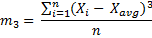

Usually there are 3 types of skewness:
1. Left Skewed data
2. Normal Distributed data
3. Right Skewed data

Here we will explore skewness graphically.

In [ ]:
# Visual Exploration of skeweness in the data
plt.subplot(3, 1, 1);
sns.distplot(rfm_data['Recency']);

plt.subplot(3, 1, 2);
sns.distplot(rfm_data['Frequency']);

plt.subplot(3, 1, 3);
sns.distplot(rfm_data['MonetaryValue'])

plt.show();

As can be seen from the visual represenation of the RFM data. All metrics are right skewed and we need to get rid from skewness by applying either Log Transformation or Z-Transformation. I prefer to do the log transformation in such case because the data has no negative values and ideally prepared for this kind of method.

In [ ]:
# Log Transform the Recency metric
rfm_data['Recency_log'] = np.log(rfm_data['Recency'])

# Log Transform the Frequency metric
rfm_data['Frequency_log'] = np.log(rfm_data['Frequency'])

# Log Transform the MonetaryValue metric
rfm_data['MonetaryValue_log'] = np.log(rfm_data['MonetaryValue'])

In [ ]:
# Visual Exploration of log transformed data
plt.subplot(3, 1, 1);
sns.distplot(rfm_data['Recency_log']);

plt.subplot(3, 1, 2);
sns.distplot(rfm_data['Frequency_log']);

plt.subplot(3, 1, 3);
sns.distplot(rfm_data['MonetaryValue_log'])

plt.show();

 Not Ideal especially with Recency value. We can see that recency_log transformed metric is still do not have a good normal shape of distribution. There are a lot some other specific methods to use such as manually perform Z-Transformation or use sklearn method such as StandardScaler.
 
 Let's try StandardScaler on log transformed data as it much more easier than to do it manually:

In [ ]:
rfm_data.head()

In [ ]:
# Choose clean values to perform again step by step transoframtion using StandardScaler
raw_rfm = rfm_data.iloc[:,:3]
raw_rfm.head()

In [ ]:
# Log Transformation
log_transformed_rfm = np.log(raw_rfm)

# Initializing a standard scaler and fitting it
scaler = StandardScaler()
scaler.fit(log_transformed_rfm)

# Scale and center data
rfm_normalized = scaler.transform(log_transformed_rfm)

# Create the final dataframe to work with a Clustering problem
rfm_normalized = pd.DataFrame(data = rfm_normalized, index = raw_rfm.index, columns = raw_rfm.columns)

In [ ]:
# Visualise the obtained results
plt.subplot(3, 1, 1)
sns.distplot(rfm_normalized['Recency'])

plt.subplot(3, 1, 2)
sns.distplot(rfm_normalized['Frequency'])

plt.subplot(3, 1, 3)
sns.distplot(rfm_normalized['MonetaryValue'])

plt.show()

Hmmm. Okay, I still do not like Recency visual representation of data. Let discover statistic values of the distribution here:

In [ ]:
# Mean
print('Mean value of the data: \n\n{}'.format(rfm_normalized.mean(axis = 0).round(2)))

# Standard Deviation
print('\nStandard Deviation value of the data: \n\n{}'.format(rfm_normalized.std(axis = 0).round(2)))

Hmmmmmmm....Seems normally distributed from statistics point of view. Ok.

So the final and most important part of our big work. Now we will implement a segmentation algorithm with k-means clustering using data we have prepared. Key step for the K-Means clustering problem:
* Data Preprocessing (done)
* Identify the number of clusters
* Run Kmeans on the preprocessed data
* Analyze average RFM values for each obtained cluster

Problem: Identifying the number of clusters. In KMeans algorithm there are several ways to identify the quantity of clusters:
* Visual method - so called elbow method (or elbow criteria and etc.)
* Quantitative method called [silhouette coefficient](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) 
* Experimentation and imagination



In [ ]:
# Initialisation of KMeans algorithm with number of cluster 4 (why I choose this I explain further)
kmeans = KMeans(n_clusters = 4, random_state = 42)

# Fit k-means cluster algorithm on the normalized data (rfm_normalized)
kmeans.fit(rfm_normalized)

# Extract the obtained cluster labels
cluster_labels = kmeans.labels_

So now we are able to analyze the obtained results with RFM values. Let's assign labes to our data.

In [ ]:
# Create a DataFrame by adding a new cluster label column
rfm_cluster_k4 = rfm_data.assign(Cluster = cluster_labels)

# Group by cluster label
grouped_clusters_rfm = rfm_cluster_k4.groupby(['Cluster'])

grouped_clusters_rfm.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)


In [ ]:
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(1, 25):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters = k, random_state = 1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(rfm_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show();

The scope of the Elbow Method is to choose the number of cluster where the graph breaks. Ususally it is number 4 so 4 clusters must be in the algorithm. Further I want to show you how to calculate base metrics to identify the 'fit' of the Kmeans algorithm. 

In [ ]:
# Calculate average RFM values for each cluster
cluster_avg = rfm_cluster_k4.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = raw_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.iloc[:, [0, 2, 5]].round(2))

In [ ]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize = (8, 4))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data = relative_imp.iloc[:, [0, 2, 5]], annot = True, fmt='.2f', cmap='RdYlGn')
plt.show()

<h3> ** Part 5. Conclusion. ** </h3>

So we have finished. It is was very interesting work. I showed to you one of the main work of marketing analytics and data science in business - identify behavioural and time cohorts of users and customers. It is a very useful technique in identifying business and marketing strategy. So if you have any questions or suggestion, so you are welcome comment. 

If you want to know more about users identification you can read more information here:
1. [6 Strategies to Increase Customer Loyalty and Retention](https://medium.com/gobeyond-ai/6-strategies-to-increase-customer-loyalty-and-retention-136544b9ad87)
2. [Marketing Analytics in SQL and Python](https://towardsdatascience.com/where-are-the-best-customers-marketing-analytics-in-sql-and-python-a20ca16968ea)
3. [Analyzing Marketing Data in Python ](https://medium.com/@tl_dr/analyzing-marketing-data-fast-in-python-d24b4387af45)

Thank You! See you next time. Good Luck!